In [1]:
import math

from openfermionpyscf import run_pyscf
from openfermion.transforms import binary_code_transform, bravyi_kitaev_code, get_fermion_operator
from openfermion.hamiltonians import MolecularData
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.utils import count_qubits
from pyscf import gto, scf, mcscf

from helper_functions import *
from XBK_method import *

In [2]:
#create molecule
name = 'H3'
charge = 1
multiplicity = 1
basis = '631g'

bond_length = 1.1
geometry = get_molGeometry(name, bond_length)

molecule = MolecularData(
    geometry=geometry,
    basis=basis,
    multiplicity=multiplicity,
    charge=charge
)

In [3]:
#run RHF calculations
molecule = run_pyscf(molecule, run_scf=True)
hf_energy = float(molecule.hf_energy)
hf_data = molecule._pyscf_data['scf']

print(hf_energy)

-1.236374104407568


In [4]:
#define active space
n_active_electrons = 2
n_active_orbitals = 3
occupied_indices, active_indices = get_active_space(molecule, n_active_electrons, n_active_orbitals)

#run CASCI calculations
casci_data = hf_data.CASCI(n_active_orbitals, n_active_electrons).run(verbose=False)
casci_energy = float(casci_data.e_tot)

print(casci_energy)

-1.2553148319654226


In [5]:
#convert to fermionic Hamiltonian
molecular_H = molecule.get_molecular_hamiltonian(occupied_indices=occupied_indices, active_indices=active_indices)
if molecular_H[()] == None:
    molecular_H[()] = 0
fermionic_H = get_fermion_operator(molecular_H)

#add penalty term to ensure correct number of electrons in ground state
weight = 5
penalty_term = FermionOperator('', n_active_electrons)

for i in range(molecular_H.n_qubits):
    penalty_term += FermionOperator(str(i)+'^ '+str(i), -1)
fermionic_H += weight*penalty_term**2

print(fermionic_H)

21.443210575236364 [] +
-21.62379810334505 [0^ 0] +
5.0 [0^ 0 0^ 0] +
5.0 [0^ 0 1^ 1] +
5.0 [0^ 0 2^ 2] +
5.0 [0^ 0 3^ 3] +
5.0 [0^ 0 4^ 4] +
5.0 [0^ 0 5^ 5] +
0.28400576352308204 [0^ 0^ 0 0] +
0.051182507589769055 [0^ 0^ 2 2] +
0.05118250758976903 [0^ 0^ 4 4] +
0.28400576352308204 [0^ 1^ 1 0] +
0.051182507589769055 [0^ 1^ 3 2] +
0.05118250758976903 [0^ 1^ 5 4] +
0.051182507589769055 [0^ 2^ 0 2] +
0.22520695976033195 [0^ 2^ 2 0] +
0.004819967321007128 [0^ 2^ 2 2] +
-0.02502497525177295 [0^ 2^ 2 4] +
-0.025024975251772906 [0^ 2^ 4 2] +
-0.004819967321007212 [0^ 2^ 4 4] +
0.051182507589769055 [0^ 3^ 1 2] +
0.22520695976033195 [0^ 3^ 3 0] +
0.004819967321007128 [0^ 3^ 3 2] +
-0.02502497525177295 [0^ 3^ 3 4] +
-0.025024975251772906 [0^ 3^ 5 2] +
-0.004819967321007212 [0^ 3^ 5 4] +
0.05118250758976903 [0^ 4^ 0 4] +
-0.025024975251772906 [0^ 4^ 2 2] +
-0.004819967321007212 [0^ 4^ 2 4] +
0.225206959760332 [0^ 4^ 4 0] +
-0.004819967321007343 [0^ 4^ 4 2] +
0.025024975251772854 [0^ 4^ 4 4] +
0.0

In [6]:
#convert to Pauli operator Hamiltonian
binary_code = bravyi_kitaev_code(molecular_H.n_qubits)
qubit_H = binary_code_transform(fermionic_H, binary_code)
qubit_H.compress()

#apply symmetry reductions and calculate minimum eigenvalue (should be equal to CASCI energy)
sectors = taper_qubits(qubit_H)
qubit_H, min_eigenvalue = sector_with_ground(sectors)
m = count_qubits(qubit_H)

print(min_eigenvalue, '\n')
print(qubit_H)

-1.2553148319654395 

11.748849714003 [] +
-0.002409983660503559 [X0] +
0.0024099836605036154 [X0 X1 X2] +
-0.012512487625886455 [X0 X1 Z2 X3] +
0.002409983660503559 [X0 X1 Z2 Z3] +
-0.012512487625886455 [X0 X1 X3] +
0.002409983660503559 [X0 X1 Z3] +
0.0024099836605036154 [X0 Y1 Y2] +
0.012512487625886429 [X0 Z1 X2 X3] +
-0.002409983660503615 [X0 Z1 X2 Z3] +
0.002409983660503669 [X0 Z1 Z2] +
-0.012512487625886429 [X0 Z1 X3] +
0.002409983660503669 [X0 Z1 Z3] +
0.012512487625886429 [X0 X2 X3] +
-0.002409983660503615 [X0 X2 Z3] +
0.012512487625886477 [X0 Z2 X3] +
-0.002409983660503559 [X0 Z2 Z3] +
-0.012512487625886453 [Y0 X1 X2 Y3] +
-0.012512487625886453 [Y0 X1 Y2 X3] +
0.0024099836605036154 [Y0 X1 Y2 Z3] +
0.012512487625886453 [Y0 Y1 X2 X3] +
-0.0024099836605036154 [Y0 Y1 X2 Z3] +
-0.012512487625886453 [Y0 Y1 Y2 Y3] +
-0.012512487625886455 [Y0 Y1 Z2 X3] +
0.002409983660503669 [Y0 Y1 Z2 Z3] +
-0.012512487625886455 [Y0 Y1 X3] +
0.002409983660503669 [Y0 Y1 Z3] +
0.012512487625886477 [Y0 Z

In [21]:
from openfermion import get_sparse_operator

result = XBK_transform(qubit_H, r=1, p=1)

In [47]:
result

24.966305642256376 [] +
2.978651055430455 [Z0] +
-2.9359800081408256 [Z0 Z1] +
8.222359524174728 [Z0 Z1 Z2] +
2.911585186453399 [Z0 Z1 Z2 Z3] +
0.32242859743359126 [Z0 Z1 Z2 Z3 Z4] +
-0.9428312046446332 [Z0 Z1 Z2 Z3 Z4 Z5] +
0.3240935954847694 [Z0 Z1 Z2 Z3 Z4 Z5 Z6] +
1.468606214250375 [Z0 Z1 Z2 Z3 Z4 Z5 Z6 Z7] +
-0.9403055786532875 [Z0 Z1 Z2 Z3 Z4 Z5 Z7] +
-0.3303768376245072 [Z0 Z1 Z2 Z3 Z4 Z6] +
-0.9465618224662307 [Z0 Z1 Z2 Z3 Z4 Z6 Z7] +
0.9135955026860808 [Z0 Z1 Z2 Z3 Z4 Z7] +
-0.32917184579425535 [Z0 Z1 Z2 Z3 Z5] +
0.3240935954847694 [Z0 Z1 Z2 Z3 Z5 Z6] +
0.32385254677147146 [Z0 Z1 Z2 Z3 Z5 Z6 Z7] +
-0.3266462198029097 [Z0 Z1 Z2 Z3 Z5 Z7] +
-0.9440361964748849 [Z0 Z1 Z2 Z3 Z6] +
-0.3329024636158529 [Z0 Z1 Z2 Z3 Z6 Z7] +
0.9135955026860808 [Z0 Z1 Z2 Z3 Z7] +
0.9135955026860808 [Z0 Z1 Z2 Z4] +
-0.9465618224662307 [Z0 Z1 Z2 Z4 Z5] +
1.468606214250375 [Z0 Z1 Z2 Z4 Z5 Z6] +
0.3240935954847694 [Z0 Z1 Z2 Z4 Z5 Z6 Z7] +
-0.9428312046446332 [Z0 Z1 Z2 Z4 Z5 Z7] +
-0.9403055786532875 [Z0 Z

In [22]:
poly = {(0,): -1, (1,): 1, (2,): 1.5, (0, 1): -1, (0, 1, 2): -2}
strength = 4
# bqm = dimod.make_quadratic(poly, 5.0, dimod.SPIN)
bqm = dimod.higherorder.utils.make_quadratic(convert_dict(result.terms), strength, dimod.SPIN)
# bqm = dimod.higherorder.utils.make_quadratic(poly, strength, dimod.SPIN)

In [23]:
qubo, constant = bqm.to_qubo()

In [24]:
deck = set()
for key in qubo.keys():
    deck.add(key[0])
    deck.add(key[1])

print(deck)

int_list = []
str_list = []
for elem in deck:
    if isinstance(elem, str):
        str_list.append(elem)
    elif (isinstance(elem, int)):
        int_list.append(elem)

print(int_list)
print(str_list)
#post processing
max_int = -1
if len(int_list) != 0:
    max_int = max(int_list)

mapping = {}

for elem in str_list:
    mapping[elem] = max_int+1
    max_int+=1

for elem in str_list:
    int_list.append(mapping[elem])

print(int_list)



{'s1', 'auxs1,s2', 's0', 's3', 'auxs0,s3', 's0*s3', 's2', 's1*s2'}
[]
['s1', 'auxs1,s2', 's0', 's3', 'auxs0,s3', 's0*s3', 's2', 's1*s2']
[0, 1, 2, 3, 4, 5, 6, 7]


In [25]:
Q = np.zeros((len(int_list), len(int_list)))
ans = qubo
for a,b in ans.keys():
    ans_one = ans[(a,b)]
    if isinstance(a, str):
        a = mapping[a]
    if isinstance(b, str):
        b = mapping[b]
    Q[a][b] = ans_one
    Q[b][a] = ans_one

In [52]:
Q.shape

(84, 84)

In [13]:
import torch
from qadence import QuantumModel

In [27]:
qubo, constant = bqm.to_qubo()

In [23]:
# Q = np.array(
#     [
#         [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
#         [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
#         [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
#         [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
#         [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
#     ]
# )

In [28]:
import numpy as np
import numpy.typing as npt
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from qadence import RydbergDevice

def qubo_register_coords(Q: np.ndarray, device: RydbergDevice) -> list:
    """Compute coordinates for register."""

    def evaluate_mapping(new_coords, *args):
        """Cost function to minimize. Ideally, the pairwise
        distances are conserved"""
        Q, shape = args
        new_coords = np.reshape(new_coords, shape)
        interaction_coeff = device.coeff_ising
        new_Q = squareform(interaction_coeff / pdist(new_coords) ** 6)
        return np.linalg.norm(new_Q - Q)

    shape = (len(Q), 2)
    np.random.seed(0)
    x0 = np.random.random(shape).flatten()
    res = minimize(
        evaluate_mapping,
        x0,
        args=(Q, shape),
        method="Nelder-Mead",
        tol=1e-6,
        options={"maxiter": 200000, "maxfev": None},
    )
    return [(x, y) for (x, y) in np.reshape(res.x, (len(Q), 2))]

In [29]:
# Loss function to guide the optimization routine
def loss(model: QuantumModel, *args) -> tuple[torch.Tensor, dict]:
    to_arr_fn = lambda bitstring: np.array(list(bitstring), dtype=int)
    cost_fn = lambda arr: arr.T @ Q @ arr
    samples = model.sample({}, n_shots=1000)[0]
    cost_fn = sum(samples[key] * cost_fn(to_arr_fn(key)) for key in samples)
    return torch.tensor(cost_fn / sum(samples.values())), {}

In [30]:
from qadence import QuantumCircuit, Register, RydbergDevice
from qadence import chain, AnalogRX, AnalogRZ

# Device specification and atomic register
device = RydbergDevice(rydberg_level=70)

reg = Register.from_coordinates(
    qubo_register_coords(Q, device), device_specs=device
)

# Analog variational quantum circuit
layers = 2
block = chain(*[AnalogRX(f"t{i}") * AnalogRZ(f"s{i}") for i in range(layers)])
circuit = QuantumCircuit(reg, block)

In [31]:
Q

array([[-24.16711412,  16.        , -10.45041392, -10.45041392,
          0.        , -30.18987842,  37.23505609,   8.        ],
       [ 16.        , -32.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  16.        ,  16.        ],
       [-10.45041392,   0.        , -24.10033278,  18.43444883,
         16.        ,   8.        , -10.45041392,  29.23505609],
       [-10.45041392,   0.        ,  18.43444883,  -4.85816701,
         16.        ,   8.        , -30.18987842,  10.35662636],
       [  0.        ,   0.        ,  16.        ,  16.        ,
        -32.        ,  16.        ,   0.        ,   0.        ],
       [-30.18987842,   0.        ,   8.        ,   8.        ,
         16.        ,  -4.85816701, -10.45041392,  10.35662636],
       [ 37.23505609,  16.        , -10.45041392, -30.18987842,
          0.        , -10.45041392, -24.16711412,   8.        ],
       [  8.        ,  16.        ,  29.23505609,  10.35662636,
          0.        ,  10.3566263

(8, 2)


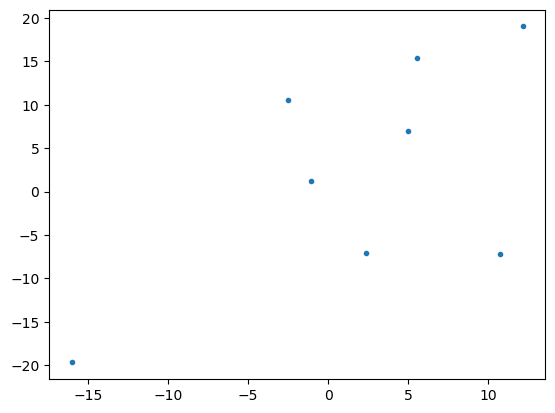

In [56]:
qubo_register_coords(Q, device)
arr = np.array(qubo_register_coords(Q, device))
print(arr.shape)

plt.plot(arr[:,0],arr[:,1],'.')

In [33]:
Q.shape

(8, 8)

In [32]:
model = QuantumModel(circuit)
initial_counts = model.sample({}, n_shots=1000)[0]

In [34]:
from qadence.ml_tools import Trainer, TrainConfig, num_parameters
import nevergrad as ng

Trainer.set_use_grad(False)

config = TrainConfig(max_iter=100)

optimizer = ng.optimizers.NGOpt(
    budget=config.max_iter, parametrization=num_parameters(model)
)

trainer = Trainer(model, optimizer, config, loss)

trainer.fit()

optimal_counts = model.sample({}, n_shots=1000)[0]

2025-03-08 23:23:02 INFO     Initializing Accelerator                                           ]8;id=896116;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py\distribution.py]8;;\:]8;id=688843;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py#108\108]8;;\

                    INFO     =============================                                      ]8;id=136593;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py\distribution.py]8;;\:]8;id=20423;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py#109\109]8;;\

                    INFO      Node, Device                : Unknown, cpu                        ]8;id=478071;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py\distribution.py]8;;\:]8;id=702904;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py#110\110]8;;\

                    INFO      Rank, Local Rank, World Size: 0, None, 1                          ]8;id=357332;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py\distribution.py]8;;\:]8;id=645661;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py#115\115]8;;\

                    INFO      Master Address, Master Port : localhost, 56526                    ]8;id=127692;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py\distribution.py]8;;\:]8;id=415944;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py#121\121]8;;\

                    INFO     User sepcifed `nprocs`=1                                           ]8;id=845277;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py\distribution.py]8;;\:]8;id=75301;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py#208\208]8;;\

                    INFO     Total processes spawned=1                                          ]8;id=257306;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py\distribution.py]8;;\:]8;id=616626;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py#209\209]8;;\

Output()

2025-03-08 23:23:08 INFO     Writing QuantumModel checkpoint                                        ]8;id=101337;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/callbacks/saveload.py\saveload.py]8;;\:]8;id=116128;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/callbacks/saveload.py#106\106]8;;\
                             model_QuantumModel_ckpt_100_device_cpu.pt                                             

                    INFO     Writing NGOpt to checkpoint opt_NGOpt_ckpt_100_device_cpu.pt           ]8;id=474847;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/callbacks/saveload.py\saveload.py]8;;\:]8;id=834933;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/callbacks/saveload.py#116\116]8;;\

In [45]:
def convert_bitstring_array(a):
    ans = []
    for i in a:
        ans.append(int(i))
    return np.array(ans)

In [50]:
energy_map = {}
for key in optimal_counts.keys():
    x = convert_bitstring_array(key)
    energy_map[key] = x.T@Q@x + constant

In [60]:
import pandas as pd

columns = mapping.keys()


In [56]:
a = [1,2,3]
b = ['b','c','a']

In [ ]:
pd.DataFrame(energy_map.keys(), columns=columns)

ValueError: Shape of passed values is (130, 1), indices imply (130, 8)

In [58]:
mapping

{'s1': 0,
 'auxs1,s2': 1,
 's0': 2,
 's3': 3,
 'auxs0,s3': 4,
 's0*s3': 5,
 's2': 6,
 's1*s2': 7}

In [65]:
len(energy_map.keys())

130

In [35]:
optimal_counts

OrderedCounter({'00100110': 36,
                '00000011': 28,
                '10000001': 28,
                '01011010': 27,
                '00000001': 22,
                '00001011': 21,
                '00011011': 20,
                '00010100': 18,
                '00010011': 17,
                '00100010': 17,
                '10010100': 17,
                '10011001': 17,
                '10101000': 17,
                '00001001': 16,
                '00100000': 16,
                '00010001': 15,
                '00010110': 15,
                '00100100': 15,
                '00101010': 15,
                '10010000': 15,
                '10010001': 15,
                '10011000': 15,
                '10100000': 15,
                '01010010': 14,
                '01011000': 14,
                '01101000': 14,
                '00011001': 13,
                '00101000': 13,
                '01010110': 13,
                '01100010': 13,
                '10000000': 13,
        

In [55]:
loss(model)

(tensor(-107.6711), {})

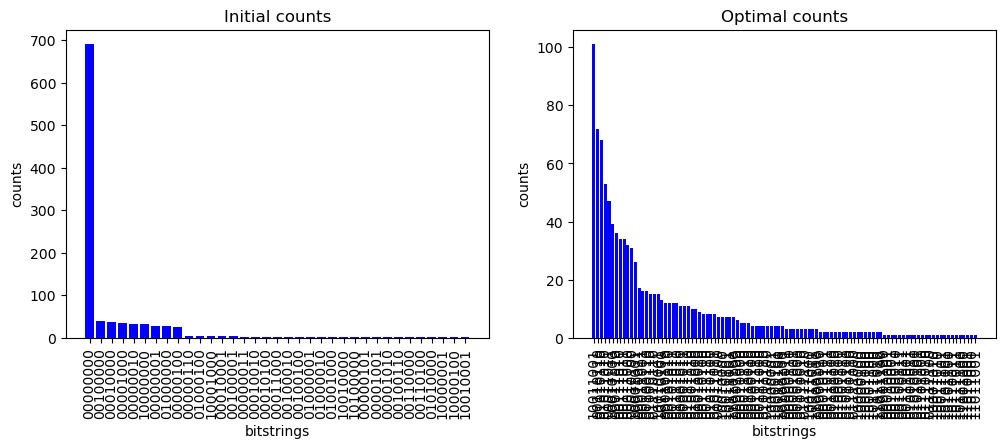

In [40]:
import matplotlib.pyplot as plt

# Known solutions to the QUBO problem.
solution_bitstrings = ["01011", "00111"]

def plot_distribution(C, ax, title):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    color_dict = {key: "r" if key in solution_bitstrings else "b" for key in C}
    ax.set_xlabel("bitstrings")
    ax.set_ylabel("counts")
    ax.set_xticks([i for i in range(len(C.keys()))], C.keys(), rotation=90)
    ax.bar(C.keys(), C.values(), color=color_dict.values())
    ax.set_title(title)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_distribution(initial_counts, axs[0], "Initial counts")
plot_distribution(optimal_counts, axs[1], "Optimal counts")

In [ ]:
#set sampler to perform the annealing
from neal import SimulatedAnnealingSampler
sampler = SimulatedAnnealingSampler() #uses simulated annealing, see D-Wave's ocean sdk for more options

In [45]:
qubit_H

11.748849714003 [] +
-0.002409983660503559 [X0] +
0.0024099836605036154 [X0 X1 X2] +
-0.012512487625886455 [X0 X1 Z2 X3] +
0.002409983660503559 [X0 X1 Z2 Z3] +
-0.012512487625886455 [X0 X1 X3] +
0.002409983660503559 [X0 X1 Z3] +
0.0024099836605036154 [X0 Y1 Y2] +
0.012512487625886429 [X0 Z1 X2 X3] +
-0.002409983660503615 [X0 Z1 X2 Z3] +
0.002409983660503669 [X0 Z1 Z2] +
-0.012512487625886429 [X0 Z1 X3] +
0.002409983660503669 [X0 Z1 Z3] +
0.012512487625886429 [X0 X2 X3] +
-0.002409983660503615 [X0 X2 Z3] +
0.012512487625886477 [X0 Z2 X3] +
-0.002409983660503559 [X0 Z2 Z3] +
-0.012512487625886453 [Y0 X1 X2 Y3] +
-0.012512487625886453 [Y0 X1 Y2 X3] +
0.0024099836605036154 [Y0 X1 Y2 Z3] +
0.012512487625886453 [Y0 Y1 X2 X3] +
-0.0024099836605036154 [Y0 Y1 X2 Z3] +
-0.012512487625886453 [Y0 Y1 Y2 Y3] +
-0.012512487625886455 [Y0 Y1 Z2 X3] +
0.002409983660503669 [Y0 Y1 Z2 Z3] +
-0.012512487625886455 [Y0 Y1 X3] +
0.002409983660503669 [Y0 Y1 Z3] +
0.012512487625886477 [Y0 Z1 Y2 X3] +
-0.00240998

In [21]:
### XBK method ###

#set r value
r = 2

#construct qubit Hamiltonians and C terms for XBK method
qubit_Hs, qubit_Cs = [],[]
for p in range(int(math.ceil(r/2+1))):
    qubit_Hs += [XBK_transform(qubit_H, r, p)]
    qubit_Cs += [construct_C(m, r, p)]

#run XBK method
XBK_energy, ground_state, solutions = XBK(qubit_Hs, qubit_Cs, r, sampler, starting_lam=0, num_samples=1000, strength=1e3, verbose=False)

print(XBK_energy)
print(ground_state) #ground state in rm-qubit space

/Users/henry/Downloads/Pasqal_Hackathon_Feb25_Team_04-main/XBK_method.py:125: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  index = int(solutions[['energy']].idxmin())
/Users/henry/Downloads/Pasqal_Hackathon_Feb25_Team_04-main/XBK_method.py:125: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  index = int(solutions[['energy']].idxmin())
/Users/henry/Downloads/Pasqal_Hackathon_Feb25_Team_04-main/XBK_method.py:125: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  index = int(solutions[['energy']].idxmin())
/Users/henry/Downloads/Pasqal_Hackathon_Feb25_Team_04-main/XBK_method.py:125: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) in

-1.23637410419178
[1, 1, 1, 1, 1, 1, 1, 1]


/Users/henry/Downloads/Pasqal_Hackathon_Feb25_Team_04-main/XBK_method.py:125: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  index = int(solutions[['energy']].idxmin())


In [57]:
new_map = {}
for i in range(8):
    new_map['s'+str(i)] = mapping['s'+str(i)]
new_map

{'s0': 33, 's1': 78, 's2': 9, 's3': 53, 's4': 37, 's5': 19, 's6': 41, 's7': 58}

In [28]:
solutions

,sample,energy,num_occurrences
0,"{'auxs0*s2,s7': 1, 'auxs0*s3,s2': 1, 'auxs0*s3...",-342034.498385,1
1,"{'auxs0*s2,s7': 1, 'auxs0*s3,s2': 1, 'auxs0*s3...",-342034.498385,1
2,"{'auxs0*s2,s7': 1, 'auxs0*s3,s2': 1, 'auxs0*s3...",-342034.498385,1
3,"{'auxs0*s2,s7': 1, 'auxs0*s3,s2': 1, 'auxs0*s3...",-342034.498385,1
4,"{'auxs0*s2,s7': 1, 'auxs0*s3,s2': 0, 'auxs0*s3...",-342034.498385,1
...,...,...,...
995,"{'auxs0*s2,s7': 1, 'auxs0*s3,s2': 0, 'auxs0*s3...",-339009.124925,1
996,"{'auxs0*s2,s7': 1, 'auxs0*s3,s2': 1, 'auxs0*s3...",-339006.465548,1
997,"{'auxs0*s2,s7': 0, 'auxs0*s3,s2': 1, 'auxs0*s3...",-338997.999259,1
998,"{'auxs0*s2,s7': 0, 'auxs0*s3,s2': 1, 'auxs0*s3...",-338949.973910,1


In [60]:
solutions.iloc[0]['sample']

{'auxs0*s2,s7': 1,
 'auxs0*s3,s2': 1,
 'auxs0*s3,s5': 1,
 'auxs0*s3,s7': 1,
 'auxs0*s3,s7*s5': 1,
 'auxs0,s2': 1,
 'auxs0,s3': 1,
 'auxs0,s5': 0,
 'auxs0,s6*s7': 0,
 'auxs0,s7': 1,
 'auxs0,s7*s5': 1,
 'auxs1,s2*s5': 1,
 'auxs2,s1': 1,
 'auxs2,s4': 1,
 'auxs2,s5': 1,
 'auxs3,s5': 1,
 'auxs3,s7': 1,
 'auxs3,s7*s5': 1,
 'auxs4*s1,s2': 1,
 'auxs4*s1,s2*s5': 1,
 'auxs4,s1': 0,
 'auxs4,s2*s5': 1,
 'auxs5,s6*s3': 0,
 'auxs5,s6*s7*s3': 1,
 'auxs6*s7,s0*s3': 1,
 'auxs6*s7,s1': 0,
 'auxs6*s7,s3': 1,
 'auxs6*s7,s4': 0,
 'auxs6*s7,s4*s1': 0,
 'auxs6,s0': 1,
 'auxs6,s0*s3': 1,
 'auxs6,s1': 1,
 'auxs6,s3': 1,
 'auxs6,s4': 1,
 'auxs6,s4*s1': 1,
 'auxs6,s7': 1,
 'auxs7,s0*s3*s2': 1,
 'auxs7,s5': 1,
 's0': 1,
 's0*s2': 0,
 's0*s2*s7': 1,
 's0*s3': 0,
 's0*s3*s2': 1,
 's0*s3*s5': 0,
 's0*s3*s7': 1,
 's0*s3*s7*s5': 1,
 's0*s5': 1,
 's0*s6*s7': 1,
 's0*s7': 0,
 's0*s7*s5': 0,
 's1': 1,
 's1*s2*s5': 0,
 's2': 0,
 's2*s1': 0,
 's2*s4': 0,
 's2*s5': 0,
 's3': 0,
 's3*s5': 0,
 's3*s7': 1,
 's3*s7*s5': 1,
 's4

In [62]:
constant

1407.3107113327292

In [61]:
for i in range(8):
    print(solutions.iloc[0]['sample']['s'+str(i)])

1
1
0
0
1
1
0
0


In [73]:
x = np.array([1, 1, 1, 1, 1, 1, 1, 1])

In [84]:
XBK_energy

-1.23637410424999

In [76]:
x.T@Q@x

71.74775296450298

In [80]:
new_map = {'s1': 0,'s2': 3,'s0': 5,'s3': 7}

In [78]:
mapping

{'s1': 0,
 'auxs1,s3': 1,
 's1*s3': 2,
 's2': 3,
 'auxs0,s2': 4,
 's0': 5,
 's0*s2': 6,
 's3': 7}

In [ ]:
from openfermion import get_sparse_operator